# Prelab 06

After having read the Introduction of the Lab manual we will investigate the performance of a PID controller on the given system. For that, we use frequency domain methods to easily simulate the closed-loop control. For the purposes of simplifying the modeling we discard the relationship between motor angles and plate pose - we skip the motors and links and assume that the output of the controller is directly the plate angle. </br>

This Jupyter notebook contains the skeleton of the code.  </br>
Put your code as well as the answers in the respective sections and hand in a single Jupyter notebook (.ipynb) file.

In [1]:
import numpy as np
from control import TransferFunction, step_response, impulse_response, tf, pade, forced_response, series, feedback
from matplotlib import pyplot as plt

###  Prelab Q1
To analyze the system, it is sufficient to only consider one of the two directions of movement. We will look at the behaviour of the PID controller with movement in x-direction. 
Calculate the open loop transfer function of this plant. You can use the linearized differential equation to calculate the transfer function.
The transfer function is given by the Laplace transform of small changes in output over small changes in the input. The constant $g$ is approximated by $10m/s^2$ (for the formula 6.6 in the lab manual). Plot the impulse and the step response of the open loop transfer function using the functions `impulse_response()` and `step_response()` from the `python-control` package. </br>

**Use a step of 0.1 magnitude**, this means your input signal wants to control the ball 10 cm off-center. </br>

On your report, show the plots as subplots next to each other and comment and explain the difference between step and impulse response and what they mean for the open-loop system. </br>

**Don't forget to add axis labels to your plots to make them readable and get full marks.**

When defining transfer functions using the `python-control` package, you can define them by specifying the polynomial coefficients of the numerator and denominator or using algebraic expressions after initializing `s=TransferFunction.s`

When manipulating transfer functions (in series, in parallel, or in feedback), there exist different ways to express the resulting transfer function of such interconnections. </br>
Look at functions that are already imported for you and their documentation to understand how they work.


Documentation: <href/> https://python-control.readthedocs.io/en/0.9.3.post2/control.html<href>

In [2]:
T = np.linspace(0, 5, 50001)

s = TransferFunction.s
g = 10

# Define transfer function of plant
P = 0.1*0.6*g/(s**2)

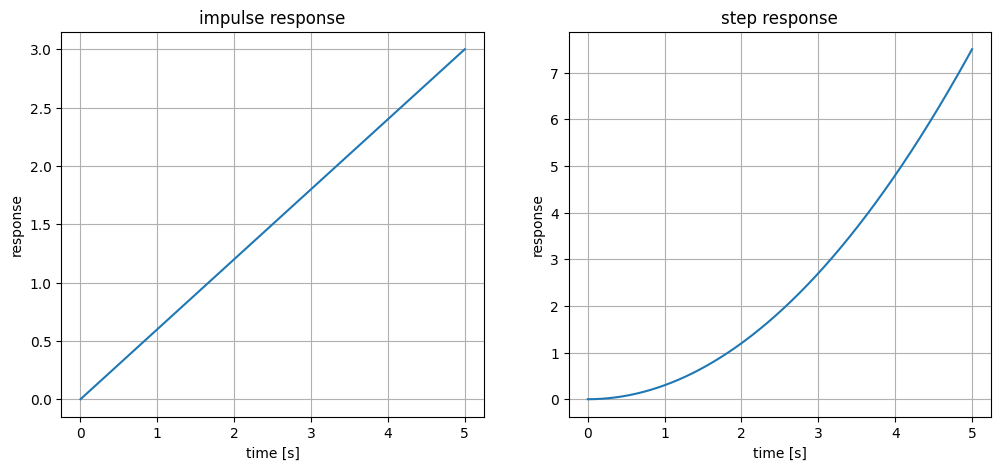

In [3]:
# Compute and plot the Impulse and step response of the uncontrolled system

_, imp = impulse_response(P, T)
_, step = step_response(P, T)

fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(T, imp)
axs[0].set_title('impulse response')
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('response')
axs[0].grid(True)

axs[1].plot(T, step)
axs[1].set_title('step response')
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel('response')
axs[1].grid(True)


Comment and explain the difference between step and impulse response and what they mean for the open-loop system </br>


<font color=green> your Answer </font>
- impulse response: the x increase linearly to the time
- step response: the x increase as quadratic function to the time

- impulse makes the ball to move constant velocity, because the dirac delta function makes the momentary acceleration and no more. (x = A*theta)
- step function makes the ball keep accelerates with constant velocity, because step the function makes the tilting angle (input) become a certain constant value. (x = A*theta^2)


### Prelab Q2

Create the transfer function of the controller and close the feedback loop according to Fig. 6.2. in the lab manual. Note that the inverse kinematics and servos are now skipped. You can further assume that the camera feedback has a transfer function of 1. For control in x-direction, this results in the simplified system depicted in the figure below. Plot the Step (0.1 magnitude) response for $K_p=20, K_i=1, K_d=2$. 

Is this response under-damped, critically damped or over-damped? 

<font color=green> your Answer </font><br/>
- under-damped


What happens to your response if you increase $K_d$ to 20? <br/>

<font color=green> your Answer </font><br/>
- Make system converge quicker, reduce oscillation.
- Thus it reduces overshoot, and faster converge.
- I see reduced peak heights in our graph.


If you consider our real system with visual feedback, what could be the risk of increasing $K_d$ too high? </br>

<font color=green> your Answer </font>
- Increase the system unstability.
- Observed with bigger $K_d$ value, the system oscillate bigger at later time.
- Reacting more sensitively to the noise, can cause fluctuation by minor error.
- It can cause the motors move too fast, can break the components.


The script that you hand in should show the plot for the two $K_d$ values and the answers to the questions above. For this Prelab, write all your answers in Markdown cells within this file.

In [4]:
# Create the transfer function of the controller with closed feedback loop and the given parameters
s = TransferFunction.s

Kp  = 20
Ki  = 1
Kd  = 2
Kd_ = 20

controller  = Kp + Ki/s + Kd*s
controller_ = Kp + Ki/s + Kd_*s

camera_feedback = 1

forward  = series(controller, P) / (1+series(controller, P))
forward_  = series(controller_, P) / (1+series(controller_, P))

T1  = np.linspace(0, 5, 50001)
T1_ = np.linspace(0, 5, 50001)

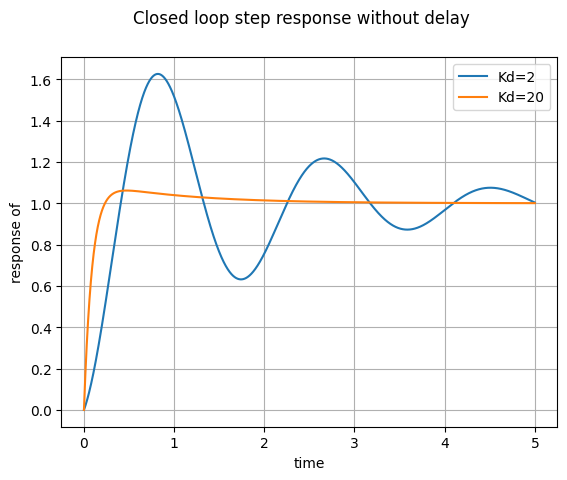

In [5]:
_, step_T1  = step_response(forward, T=T1)
_, step_T1_ = step_response(forward_, T=T1_)

fig, axs = plt.subplots(1, 1)

fig.suptitle("Closed loop step response without delay")

axs.plot(T1, step_T1, label='Kd=2')
axs.plot(T1_, step_T1_, label='Kd=20')
axs.set_xlabel('time')
axs.set_ylabel('response of')
axs.legend()
axs.grid(True)

### Prelab Q3

The real system has a small latency due to the image-processing part happening on the Pixy cam. Although the setup with the Pixy cam minimizes this delay, it could still be big enough to impact our controller design.

Simulate this time-delay by adding it to our control loop. A time delay in the frequency domain is given by the exponential function $e^{−sT}$, where $s$ is the Laplace variable and $T$ is the delay. 

If we assume that the pixycam introduces a delay of 80ms, you will see that the system is no longer stable.

Find parameters that stabilize the system with a steady state error at 5 seconds that is smaller than 0.001 (=1mm) for a step input of 0.1 magnitude. Make sure to print the steady state error and plot the obtained response. 

If you increase the delay to 1 second it will be difficult to stabilize the system within 5 seconds, what is the fundamental reason for that?


<font color=green> your Answer </font><br/>
The controller give input (control) based on the dynamics of 1 second before. So it is no more valid after 1 second when the signal arrived. It can cause rather increment of wave, or fluctuation that grows as time goes.


The `python-control` library cannot express time delay as an exponential function. Therefore, we will use the `pade` function, which approximates the delay, expressed as a rational function.

The `pade` function takes as arguments, the desired delay and the degree of the denominator approximation, and returns the numerator and the denominator of the approximated delay.

https://python-control.readthedocs.io/en/latest/generated/control.pade.html?highlight=Pade
</br>

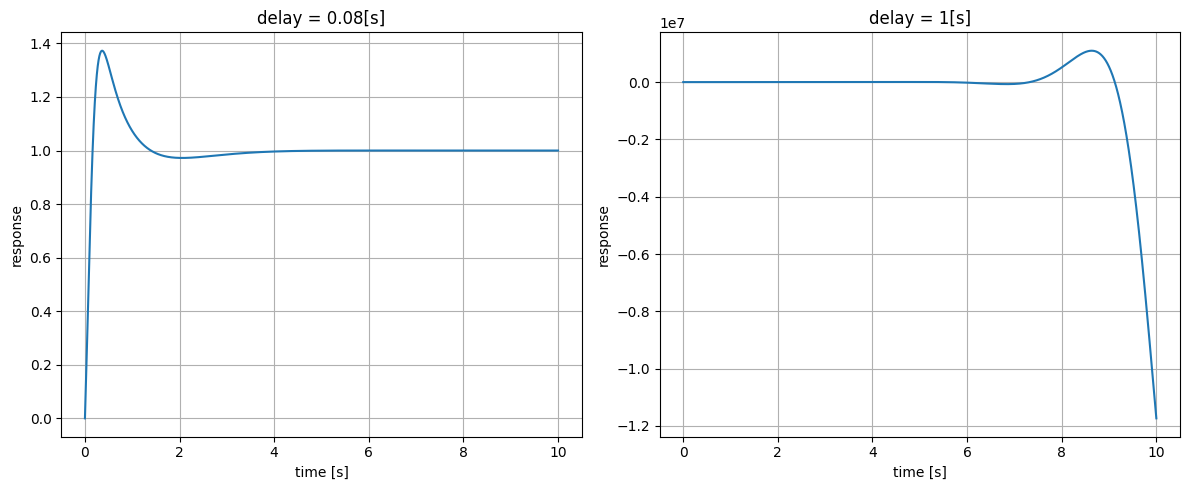

In [6]:
s = TransferFunction.s

Kp, Ki, Kd = 20, 15, 10
delay, delay_ = 0.08, 1

N_pade = [TransferFunction(*pade(delay, 3)), TransferFunction(*pade(delay_, 3))]
controller = (Kp + Ki/s + Kd*s)

Hdelay  = series(controller, P) / (1 + series(N_pade[0], controller, P))
Hdelay_ = series(controller, P) / (1 + series(N_pade[1], controller, P))

T2  = T1  = np.linspace(0, 10, 50001)
T2_ = T1  = np.linspace(0, 10, 50001)

# Calculate and plot the closed loop step response with delay
_, step_T2  = step_response(Hdelay, T2)
_, step_T2_ = step_response(Hdelay_, T2_)

fig, axs = plt.subplots(1,2, figsize=(12,5))

axs[0].plot(T2, step_T2)
axs[0].set_title('delay = 0.08[s]')
axs[0].set_xlabel('time [s]')
axs[0].set_ylabel('response')
axs[0].grid(True)

axs[1].plot(T2_, step_T2_)
axs[1].set_title('delay = 1[s]')
axs[1].set_xlabel('time [s]')
axs[1].set_ylabel('response')
axs[1].grid(True)

fig.tight_layout()

In [7]:
# Print your steady state error for both delays

error = [step_T2[-1]-1, step_T2_[-1]-1] # It is almost impossible to find the point that converge for 1s delay
print(error)

[-2.0462091065986954e-07, -11733632.558067352]


### Prelab Q4

When analyzing the system further you notice that the PID controller’s output exceeds the speed limits of your motors. What could be one of the problems you face?

<font color=green> your Answer </font>
- The exceed input may saturate the motor, that is not controlled beyond its limit. it loses the control to make the system stable as calculated. 
- Motor can show unexpected movement, and does not fulfill the command. it disturbes the stable control.